In [94]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
from IPython.display import Image
from collections import Counter
import random
from sklearn import datasets, mixture 
from sklearn.cluster import DBSCAN
    
'''   
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
'''

'   \ndef fxn():\n    warnings.warn("deprecated", DeprecationWarning)\n\nwith warnings.catch_warnings():\n    warnings.simplefilter("ignore")\n    fxn()\n'

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

# Loading and Pre-Processing

The dataset is from one 63 year old white male exported from the Apple Health app. A default field list is generated. Unfortunetly, attributes such as activity type, are not collected. For this project, only the heart rate, in beats per minute (bpm), will be analyzed. 

In [3]:
# The dataset for this project consist of heart rate data collected over 4 years 
# during various physical activities: biking, walking, skiing. 
#csv_file = 'data/HeartRateDataRaw.csv'
#df_raw = pd.read_csv(csv_file, header=0)
#df_raw.to_pickle('./data/HeartRateDataRaw.pickle')
df_raw=pd.read_pickle('./data/HeartRateDataRaw.pickle')

In [4]:
# Displaying the list of column names in the heart rate export: 
for col in df_raw.columns:
    print (col)

/@locale
/ExportDate/@value
/Me/@HKCharacteristicTypeIdentifierBiologicalSex
/Me/@HKCharacteristicTypeIdentifierBloodType
/Me/@HKCharacteristicTypeIdentifierDateOfBirth
/Me/@HKCharacteristicTypeIdentifierFitzpatrickSkinType
/Record/@creationDate
/Record/@device
/Record/@endDate
/Record/@sourceName
/Record/@sourceVersion
/Record/@startDate
/Record/@type
/Record/@unit
/Record/@value
/Record/MetadataEntry/@key
/Record/MetadataEntry/@value
/Record/MetadataEntry/@value/#agg


In [5]:
# Saving and renaming only the BPM values: 
df_raw = df_raw.filter(items=['/Record/@value'])
df_raw = df_raw.rename(columns={'/Record/@value':"BPM"})


# Setting Configuration and Limit Parameters
## Hardware Limits, Sample Size, Maximum HR 

The heart rate data was obtained from an Apple Watch and exported from Healthkit. Do to the sensitivity and availability of health data, the dataset is collected from only one white 63 year old male. The watch sensor's valid limits are from 30 bpm to 210 bpm. Values outside of this range are filtered. Do to the large database with over 349,000 data points, a random sample was generated. This did not significantly affect the distribution or results but did improve execution time. 

Maximum heart can be calculated from age. The formula is 220-age. There is no comparable algorithm for minimum heart rate. In general, a lower resting heart rate is indicative of better conditioning. 

In [6]:
# Configuration Parameters including hardware sensor limits, maximum heart rate and sample size are defined. 
# To calculate maximum heart rate, the formula 220 - age is used. 
age = 63 
max_hr = 220-age
sample_size = 10000
hardware_upper_limit = 210
hardware_lower_limit = 30

## Heart Rate Zone Limits from the CDC, Mayo Clinic and Polar (tm)

Various heart rate zones have been defined from resting heart rates to high intensity heart rates. There is no standard. Polar heart rate monitors have been in use by atheletes for decades. They define 5 zones with the highest zone reserved for high intensity workouts from elite atheletes. The CDC and Mayo clinic define two exercise zones, moderate and intense. The resulting of the clusting algortihms will be compared to these 3 different sources. 
The limits for these zones are defined in a dictionary below: 

In [7]:
#Dictionaries are defined for Mayo Clinic, CDC and Polar (tm) heart rate zones: 
mayo_limits = {'moderate_low':0.50*max_hr,'moderate_hi':0.7*max_hr,'intensity_low':0.70*max_hr,'intensity_hi':0.85*max_hr}
cdc_limits = {'moderate_low':0.64*max_hr,'moderate_hi':0.76*max_hr,'intensity_low':0.76*max_hr,'intensity_hi':0.93*max_hr}
polar_limits = {'zone1':0.6*max_hr,'zone2':0.7*max_hr,'zone3':0.80*max_hr,'zone4':0.9*max_hr,'zone5':1*max_hr}

## Explore the Data
With the data of interest selected, it is now time to explore the data. A display of the raw dataframe, summary
statistics and graphical analysis will all be used to understand the dataset. 

In [8]:
# The summary statistics for heart rate data on the full dataset: 
display (round(df_raw.BPM.describe()))

count    349781.0
mean         78.0
std          24.0
min           5.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64

### Sampling 
In order to reduce execution times, sampling from the original dataset was done. The below results show that the sample distribution accurately reflects the population from which it was drawn. In addition, later on the silhouette score was also unaffected by the sampling process. 


In [9]:
#To improve execution times, a random sample of 10,000 from the population of 349,768 is drawn. By comparing the 
#percentiles of the population above to that of the sample below, it can be seen the sample actuately 
#reflects the population. 

df_s=random.sample(list(df_raw.BPM), sample_size)
df_sample = pd.DataFrame(df_s)
df_sample.columns=['BPM']
print (round(df_sample.describe()))

           BPM
count  10000.0
mean      78.0
std       24.0
min       30.0
25%       61.0
50%       69.0
75%       86.0
max      215.0


In [10]:
# Now the hardware limits are being applied to the data:

df_limit = df_sample[(df_sample['BPM'] < hardware_upper_limit) & (df_sample['BPM'] > hardware_lower_limit) ]
num_screened = df_sample.shape[0]-df_limit.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} data points.".format(hardware_upper_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 15 data points.


In [11]:
def plot_data_histo(totals): 
    
    '''This method will be used to plot the heart rate distribution. The data will be
       from the 'BPM' column, the same column used for the above summary statistics. 
    '''
    
    xref = [max_hr]
    ref_colors=['r']
    plt.figure(figsize=(5,3))
    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    
    # Setting up the grids: 
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Raw Heart Rate Distribution')
    #plt.ylim(0,35000)
    #plt.xlim(30,200)
    plt.hist(df_raw.BPM, bins=range(35, 205+2, 2))
    plt.savefig('./plots/raw_histo.png')
    plt.show()

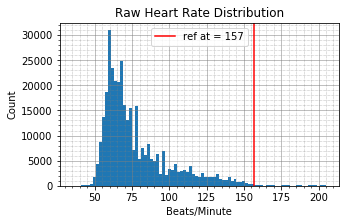

In [22]:
plot_data_histo(df_limit.BPM)

#### Heart Rate Distribution 
Note how the distribution is continuous. No clear second distibution or cluster sticks out. Also note that the maximum heart rate calculation, 220-age or 158 in this case, compares well to the maximum histogram value. There are data points above 158, but they are likely outliers. 

## Pre-Processing Summary
The dataset has been loaded, columns of interest selected, data filtered for valid hardware limits and a smaller sample generated to speed execution. Summary statistics and graphical analysis have also been completed. This is a simple 1D dataset with no features or labels.
#### Training and Test Sets
The data has not been segregated into training and test sets. This is becaused it is un-supervised learning. There are no labels for model predictions to be compared against. Instead a 'score', explained more below, will be used to evaluate the model with the best fit. 

# Modeling 
## KMeans 
This model was selected as it does not required labeled data and it is intuitive to understand. One primary question to be answered is whether or not a high intensity, high heart rate cluster, separate from lower intensity clusters could be indentified. This would allow for personalized high intensity zones to be defined. 

### Fitting, Predicting and Evaluating the Model
The primary hyperparameter of interest is the number of clusters. It is the first step in optimizing the model. Values from 2 to 10 were used. The data was fit and model predictions were used to define labels. 

The KMeans performance metric is called its score or inertia. It measures the mean square distance from the instance to the cluster centroid. Lower numbers are considerted to be better. 

In [12]:
def scree_KMeans_plot(data,num_clusters):
    
    ''' This method will calculate Kmeans clusters. The number of clusters will be defined by a range. 
        Kmeans will be used to define the clusters and labels for the data generated. Finally the data 
        will be ploted so the Elbow method can be used to determine the optimum number of clusters. 
    '''
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        #print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        #print ("Cluster Labels: ",np.unique(labels))
        score = -(kmeans.score(data))
        #print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Elbow Method: Number of Clusters vs KMeans Score')
    plt.savefig('./plots/Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    #print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels

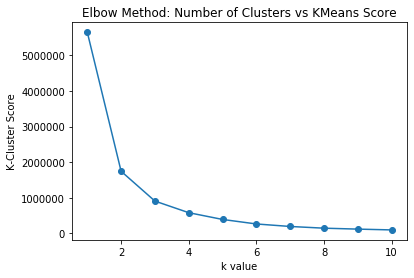

In [13]:
k_values, scores, labels = scree_KMeans_plot(df_sample,11) 

In [14]:
print ("KMeans Labels: ",np.unique(labels)) 

KMeans Labels:  [0 1 2 3 4 5 6 7 8 9]


#### KMeans Score or Inertia
For each of the clusters numbered 2 to 10, the score was calculated and compared to k. The plot is above. It can be seen that after 5 clusters the improvment in score diminishes. This rather crude method, also called the Elbow method, suggests that after 5 clusters the improvement diminishes. 5 cluster would also make the comparison to the Polar (tm) methodology straight forward.

Another method, listed below, was written to specify a percentage improvement in the score at which the addition of more clusters is no longer beneficial.  

In [15]:
# The elbow method would suggest that most of the improvement in the cluster scores happens prior to k=5.
# The algorithm below allows for selection of k based on the diminishing benefits of increasing clusters. 
# 5 clusters is being chosen, not just by the elbow method above as it also matches up with the 5 zones 
# defined by the Polar (tm) methodology. 

def findK(df,limit): 

    for k in range(len(df)):
        if k == len(df):
           print ("\nEnd of array reached.") 
        elif k == len(df): 
          improvement = 'None'
          print ("end of array reached prior to limit")
          print ("K=0")
        elif k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k-1])))
          #print (k,round(df[k]/100000000,2),improvement)
          if improvement < limit:
                #print ("Improvement of {}% is less than lower limit of {}% for k = {}. k max is {} ".format(improvement,limit,k,len(df)))
                break
    print ("Maximum value of number of clusters (k) is: ",len(df))
    print ("Less than {}% improvement in score after k = {}".format(limit,k))
findK(scores,30) 

Maximum value of number of clusters (k) is:  10
Less than 30% improvement in score after k = 6


#### KMeans Silhouette Score
A second performance metric was also used to evaluate the model performance. It is called the silhouette score and is more robust than the inertia score.  It comprehends both cohesion, or intra-cluster distances,  as well as the inter-cluster distances, or separation.

In [16]:
def silhouetteScore(df,num_clusters): 
    sil_scores = []
    k_value = []
    start = timer()
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
        #kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        k_value.append(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(df)
        score = round(silhouette_score(df,cluster_labels),2)
        sil_scores.append(score)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        #print(f"Function in {(end - start)/60:0.1f} minutes")
    print ("\nFinished!")
    return sil_scores, k_value

In [19]:
%%time
# The silhouette score is computationally expensive. The timer helps in monitoring.
sil_scores, k_value = silhouetteScore(df_sample.BPM.values.reshape(-1,1),11)

For n_clusters = 2, silhouette score is 0.7
For n_clusters = 3, silhouette score is 0.63
For n_clusters = 4, silhouette score is 0.59
For n_clusters = 5, silhouette score is 0.59
For n_clusters = 6, silhouette score is 0.56
For n_clusters = 7, silhouette score is 0.55
For n_clusters = 8, silhouette score is 0.55
For n_clusters = 9, silhouette score is 0.56
For n_clusters = 10, silhouette score is 0.53

Finished!
CPU times: user 12.1 s, sys: 2.22 s, total: 14.3 s
Wall time: 14.3 s


In [20]:
def silhouette_plot(scores, k_value):
    plt.figure(figsize=(5,3))
    plt.ylabel('Silhouette Coefficient')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_value, scores, marker = 'o')

    plt.show()

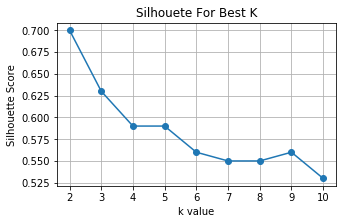

In [21]:
silhouette_plot(sil_scores,k_value)

The silhouette coefficient can vary from -1 to 1. Values near 1 mean that the instance is well within its cluster and far from other clusters. So higher is better. As can be seem from the plot above, the best fit is with a cluster of 2. Note that 2 is the minimum number of clusters that can be used for the silhouette calculation. 

This differs from the kmeans score results that saw improvements down to 5 or more clusters. This is because the score always increases as we add more clusters since the instance to cluster centroid distance will diminish. 

## Clustering and the Distribution
The next section will look at how the predicted clusters compare to the overall distribution 

In [36]:
# This method will divide up the bpm histograms by the chosen number of clusters, 5 in this case, 
# and plot the results: 

def hr_cluster_histogram(df): 
    ''' This method will plot the heart rate distribution and color the clusters
        that compose it. 
    '''
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    
    kmeans = KMeans(n_clusters=5)
    model = kmeans.fit(df)
    centers = np.round(model.cluster_centers_,0)
    print ("Percent of Values in each cluster: ")
    labels = kmeans.predict(df)  
   
    df.insert(1,"Label",labels)

    clusterCounts(labels)

    xref = [max_hr]
    ref_colors=['r']
        
    zone1 = df.loc[df.Label ==0, 'BPM']
    zone2 = df.loc[df.Label ==1, 'BPM']
    zone3 = df.loc[df.Label ==2, 'BPM']
    zone4 = df.loc[df.Label ==3, 'BPM']
    zone5 = df.loc[df.Label ==4, 'BPM']
    
    # Setup plot:
    plt.figure(figsize=(5,3))
  
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')

    plt.title('Cluster Heart Rate Distribution')
    plt.hist(zone1,  color='b', label='Cluster 1', bins=range(35, 205, 2))
    plt.hist(zone2,  color='c', label='Cluster 2', bins=range(35, 205, 2))
    plt.hist(zone3,  color='g', label='Cluster 3', bins=range(35, 205, 2))
    plt.hist(zone4,  color='y', label='Cluster 4', bins=range(35, 205, 2))
    plt.hist(zone5,  color='r', label='Cluster 5', bins=range(35, 205, 2))
    plt.legend()
   
    plt.savefig('./plots/cluster_histo.png')
    plt.show()

In [37]:
# The function below calculates the percent of the distribution in each cluster. 
def clusterCounts(labels): 
    clusterDict = collections.Counter(labels)
    clusterSum = sum(clusterDict.values())

    for key,value in sorted(clusterDict.items()): 
        print (key +1, ' ->',np.round(100*value/clusterSum),'%')

Percent of Values in each cluster: 
1  -> 55.0 %
2  -> 12.0 %
3  -> 26.0 %
4  -> 1.0 %
5  -> 7.0 %


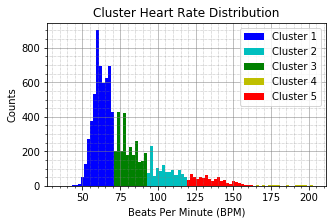

In [38]:
hr_cluster_histogram(df_sample)

### Clustering Partitions on the Distribution
This histogram show clearly that although KMeans succesfully partioned the data into clusters, there is no separation between clusters, suggesting the model has overfit the data. 

## Benchmarking
The next section will compare how several sources, the Mayo Clinic, the CDC and the Polar Heart Rate company, define high intensity heart rates zones. These zones will be used as benchmarks for the ones defined by the clustering algorithm. 

The overall process is outlined below. 
###  Maximum Heart Rate
The first step in determining high intensity heart rate zones is to determine maximum heart rate. There are several methods for this: 

1. 220 - age. 0r 158bpm for a 62 year old.
2. Heart Rate Monitor data collected over a period of months with various activities. 
3. Using a treadmill or stationary bike with an ECG. 
Option number 1 is the most common for folks that do not have access to the treadmill and ECG. It is remarkable how well it works. The body seems to have a built in algorithm.  
After the maximum heart rate is determined, target heart rates can be determined:

### Hear Rate Intensity Zones

#### CDC
The CDC defines zones as follows: 
* Target Heart Rate is 64% to 76%. CDC. 
* High Intensity target heart rate is 76-93% (CDC). Or 120 to 146 for the 62 year old. 

#### MayoClinic
The Mayo Clinic defines 

1. Moderate intensity as 50-70% of maximum heart rate.
2. Vigorous as 70% to 85%.

#### Polar
The heart rate monitor company Polar suggests 5 heart rate zones:

1. Very light at 50-60% of HRMAX. Boost recovery and prepare for higher zones.
2. Light 60-70%. Improve general endurance and increase capillary density.
2. Moderate at 70-80%. Lactic acid build up,improve efficiency of blood circulation in the heart and muscles
4. Hard 80-90%. Improve speed endurance.
5. Maximum 90-100%. For elite atheletes to further improve speed. 

The code below will assign new columns in the dataset that categorize the heart rate into the zones covered above: 


In [77]:
def assignZone(value):
    '''
    Polar Heart rate zones are defined below
    '''
    if (value <= polar_limits['zone1']): 
        return "zone1"
    elif (value > polar_limits['zone1']) and (value <= polar_limits['zone2']):
        return "zone2"
    elif (value > polar_limits['zone2']) and (value <= polar_limits['zone3']):
        return  "zone3"
    elif (value > polar_limits['zone3']) and (value <= polar_limits['zone4']):
        return  "zone4"    
    elif (value > polar_limits['zone4']) and (value <=polar_limits['zone5']):
        return "zone5"
    else:
        return

print ("Polar: {} {} {} {} {} ".format(int(polar_limits['zone1']),int(polar_limits['zone2']),int(polar_limits['zone3']),int(polar_limits['zone4']),int(polar_limits['zone5'])))

Polar: 94 109 125 141 157 


In [42]:
print ("CDC Limits: ",int(cdc_limits['moderate_low']),int(cdc_limits['moderate_hi']), int(cdc_limits['intensity_low']),int(cdc_limits['intensity_hi']))
def assignCDCZone(value):
    '''
    CDC Definitions are defined here:
    '''
    if (value > cdc_limits['moderate_low']) and (value <= cdc_limits['moderate_hi']):
        return "Moderate"
    elif (value > cdc_limits['intensity_low']) and (value <= cdc_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

CDC Limits:  100 119 119 146


In [45]:
print ("Mayo Clinic Limits: ",int(mayo_limits['moderate_low']),int(mayo_limits['moderate_hi']), int(mayo_limits['intensity_low']),int(mayo_limits['intensity_hi']))
def assignMayoZone(value):
    '''
    Mayo Clinic heart rate zones are defined below
    '''
    if (value > mayo_limits['moderate_low']) and (value <= mayo_limits['moderate_hi']):
        return "Moderate"
    elif (value > mayo_limits['intensity_low']) and (value <= mayo_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

Mayo Clinic Limits:  78 109 109 133


In [81]:
df_zones=df_sample.copy()
df_zones['Polar_Zone'] = df_zones.BPM.apply(assignZone)
df_zones['CDC_Zone'] = df_zones.BPM.apply(assignCDCZone)
df_zones['Mayo_Zone'] = df_zones.BPM.apply(assignMayoZone)
print (df_zones.shape)

print ("\nHere is what the dataframe header looks like with these zones applied:")
df_zones.head()

(10000, 5)

Here is what the dataframe header looks like with these zones applied:


BPM  Label Polar_Zone CDC_Zone Mayo_Zone
0  61.0      0      zone1    Other     Other
1  84.0      2      zone1    Other  Moderate
2  62.0      0      zone1    Other     Other
3  58.0      0      zone1    Other     Other
4  96.0      1      zone2    Other  Moderate

In [49]:
#Checking for Zone assignment: 
print ("Polar: ",df_zones['Polar_Zone'].unique())
print ("CDC  : ",df_zones['CDC_Zone'].unique())
print ("Mayo : ",df_zones['Mayo_Zone'].unique())

Polar:  ['zone1' 'zone2' 'zone3' 'zone5' 'zone4' 'nan']
CDC  :  ['Other' 'Intensity' 'Moderate']
Mayo :  ['Other' 'Moderate' 'Intensity']


In [51]:
df2 = df_zones.copy() 

### Zone Histograms
The next two modules define methods to superimpose the zones onto the hear rate dataset.

In [64]:
def hr_polar_histogram(df): 

    zone1 = df.loc[df.Polar_Zone == 'zone1', 'BPM']
    zone2 = df.loc[df.Polar_Zone == 'zone2', 'BPM']
    zone3 = df.loc[df.Polar_Zone == 'zone3', 'BPM']
    zone4 = df.loc[df.Polar_Zone == 'zone4', 'BPM']
    zone5 = df.loc[df.Polar_Zone == 'zone5', 'BPM']
    
    xref = [max_hr]
    ref_colors=['r']
    
    plt.figure(figsize=(5,3))
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    #plt.grid(True)
    plt.title('Polar(tm) Zone Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='g', label='Zone 1', bins=range(35, 205+2, 2))
    plt.hist(zone2, **kwargs, color='b', label='Zone 2', bins=range(35, 205+2, 2))
    plt.hist(zone3, **kwargs, color='r', label='Zone 3', bins=range(35, 205+2, 2))
    plt.hist(zone4, **kwargs, color='c', label='Zone 4', bins=range(35, 205+2, 2))
    plt.hist(zone5, **kwargs, color='y', label='Zone 5', bins=range(35, 205+2, 2))
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
    plt.legend()
    plt.savefig('./plots/zone_histo.png')
    plt.close()
    #plt.show()

In [66]:
def hr_3zone_histogram(df,source): 

    if source == 'Mayo':
        zone1 = df.loc[df.Mayo_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.Mayo_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.Mayo_Zone == 'Other', 'BPM']

    
    if source == 'CDC':
        zone1 = df.loc[df.CDC_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.CDC_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.CDC_Zone == 'Other', 'BPM']


    xref = [max_hr]
    ref_colors=['r']
    bin = 50
    plt.figure(figsize=(5,3))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    
    #plt.grid(True)

    plt.title(source + ' Clinic Zone Heart Rate Distribution')
        
    plt.hist(zone1, **kwargs, color='g', label='Moderate',bins=range(35, 205+2, 2))
    plt.hist(zone2, **kwargs, color='b', label='Intensity',bins=range(35, 205+2, 2))
    plt.hist(zone3, **kwargs, color='r', label='Other',bins=range(35, 205+2, 2))

    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
    plt.legend()
    if source == 'Mayo': 
        plt.savefig('./plots/mayo_histo.png')
    if source == 'CDC': 
        plt.savefig('./plots/cdc_histo.png')
    plt.close()
    #plt.show()

#### Generating and Saving Histograms 

In [67]:
hr_polar_histogram(df2)

In [68]:
hr_3zone_histogram(df2,'CDC')

In [69]:
hr_3zone_histogram(df2,'Mayo')

#### Displaying the Histograms
The four histograms, one each for the clusters, CDC, Mayo and Polar are shown: 

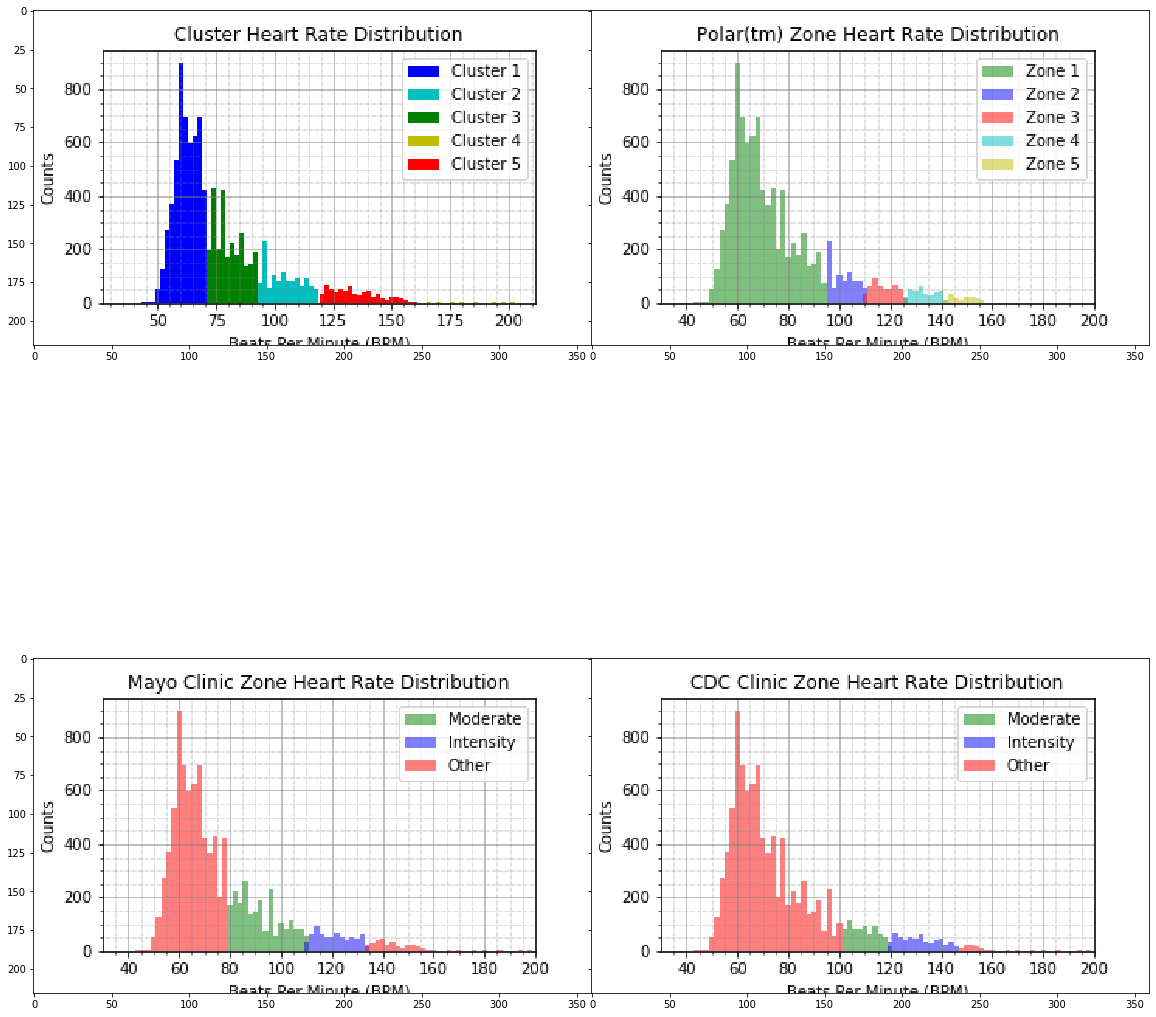

In [70]:
import matplotlib.gridspec as gridspec

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,sharey=True)

img1 = imageio.imread('./plots/cluster_histo.png')
img2 = imageio.imread('./plots/zone_histo.png') 
img3 = imageio.imread('./plots/mayo_histo.png')
img4 = imageio.imread('./plots/cdc_histo.png')

plt.rcParams["figure.figsize"] = (20,20)
#gs1 = gridspec.GridSpec(4, 4)
#gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes
fig.subplots_adjust(wspace=0, hspace=0,bottom = 0,top = 0.9)

#fig,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)
#plt.subplot(2,1,1)
#plt.figure()

ax1.imshow(img1)                     
#plt.subplot(212) 
ax2.imshow(img2) 
ax3.imshow(img3) 
ax4.imshow(img4) 
plt.show()

### Discussion 
The clustering algorithm defines 5 zones but the boundaries seem artifical. The Polar algoritm seems to suffer from the same plight, but has a larger resting (Zone 1 & Zone 2) percentage. The Mayo Clinc and CDC Zones have an intensity session defined that provides a buffer to the maximum heart rate. 

### Next Steps 
Providing more features and data from more persons need to be added to the dataset. 

In [ ]:
#Single Link, Complete Lnk, Ward, 

In [198]:
%%time
def silhouetteScore2(df,num_clusters):
    models = ['kmeans', 'gmm', 'dbscan']
    sil_scores = []
    k_value = []
    model_type = []
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
            for mymodel in models:
                    if mymodel == 'kmeans':
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            kmeans = KMeans(n_clusters=n_clusters)
                            cluster_labels = kmeans.fit_predict(df)
                            score = round(silhouette_score(df,cluster_labels),2)
                            sil_scores.append(score)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
                    
                    elif mymodel == 'gmm': 
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            gmm = mixture.GaussianMixture(n_components=n_clusters)
                            cluster_labels = gmm.fit_predict(df)
                            score = round(silhouette_score(df,cluster_labels),2)
                            sil_scores.append(score)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
                    
                    elif mymodel == 'dbscan':
                            k_value.append(n_clusters)
                            model_type.append(mymodel)
                            dbscan = DBSCAN(eps=3, min_samples= 30)
                            cluster_labels = dbscan.fit_predict(df)
                            score = round(silhouette_score(df,cluster_labels),2)
                            sil_scores.append(score)
                            print("Model {} with n_clusters = {}, silhouette score is {}".format(mymodel,n_clusters, score))
 
    print ("\nFinished!")
    return sil_scores, k_value, model_type

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 7.15 µs


In [199]:
%%time
sil_scores_gmm, k_value_gmm, model_type_gmm = silhouetteScore2(df_sample.BPM.values.reshape(-1,1),6)

Model kmeans with n_clusters = 2, silhouette score is 0.7
Model gmm with n_clusters = 2, silhouette score is 0.66
Model dbscan with n_clusters = 2, silhouette score is 0.75
Model kmeans with n_clusters = 3, silhouette score is 0.63
Model gmm with n_clusters = 3, silhouette score is 0.62
Model dbscan with n_clusters = 3, silhouette score is 0.75
Model kmeans with n_clusters = 4, silhouette score is 0.58
Model gmm with n_clusters = 4, silhouette score is 0.6
Model dbscan with n_clusters = 4, silhouette score is 0.75
Model kmeans with n_clusters = 5, silhouette score is 0.59
Model gmm with n_clusters = 5, silhouette score is 0.55
Model dbscan with n_clusters = 5, silhouette score is 0.75

Finished!
CPU times: user 19.3 s, sys: 3.42 s, total: 22.7 s
Wall time: 20.6 s


In [200]:
print (len(sil_scores_gmm),len(k_value_gmm), len(model_type_gmm))

12 12 12


In [201]:


print (list(all))
df =pd.DataFrame(list(zip(sil_scores_gmm,k_value_gmm,model_type_gmm)),columns=['sil_score','k','model'])
display (df.head(20))

[]


sil_score  k   model
0        0.70  2  kmeans
1        0.66  2     gmm
2        0.75  2  dbscan
3        0.63  3  kmeans
4        0.62  3     gmm
5        0.75  3  dbscan
6        0.58  4  kmeans
7        0.60  4     gmm
8        0.75  4  dbscan
9        0.59  5  kmeans
10       0.55  5     gmm
11       0.75  5  dbscan

In [261]:
def silhouette_plot2(df):
    
    kmeans = df.loc[df.model == 'kmeans']
    gmm = df.loc[df.model == 'gmm']
    dbscan = df.loc[df.model == 'dbscan']
    plt.figure(figsize=(5,3))
    plt.ylabel('Silhouette Coefficient')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.3,1.0)
    plt.grid(True)
    plt.plot(kmeans.k,kmeans.sil_score,  label = 'kmeans', marker = 'o')
    plt.plot(gmm.k,gmm.sil_score,  label = 'gmm', marker = 'o')
    plt.plot(dbscan.k,dbscan.sil_score,  label = 'gmm', marker = 'o')

    plt.xticks(np.arange(1.0, 11, 1.0))
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.legend(['kmeans', 'gmm','dbscan'])
    plt.show()

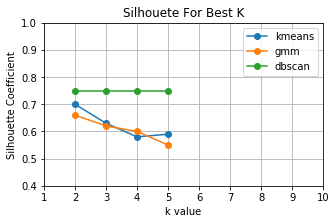

In [262]:
silhouette_plot2(df)

In [197]:
dbscan = DBSCAN( min_samples=6)
dbscan

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=6, n_jobs=None, p=None)

In [220]:
df3 = df.loc[df.model == 'dbscan']

dbscan = DBSCAN(eps=5, min_samples= 30)
cluster_labels = dbscan.fit_predict(df_sample.BPM.values.reshape(-1,1))
score = silhouette_score(df_sample.BPM.values.reshape(-1,1),cluster_labels)
print (score)

0.7647318339230184


In [250]:
%%time
scores = []
for x in range(2,16,2):
    dbscan = DBSCAN(eps=x, min_samples= 100)
    dbscan.fit(df_sample.BPM.values.reshape(-1,1))

    score = silhouette_score(df_sample.BPM.values.reshape(-1,1),dbscan.labels_)
    print (x,np.unique(dbscan.labels_),round(score,2))

    

2 [-1  0  1] 0.59
4 [-1  0] 0.72
6 [-1  0] 0.76
8 [-1  0] 0.76
10 [-1  0] 0.77
12 [-1  0] 0.77
14 [-1  0] 0.78
CPU times: user 11.7 s, sys: 2.75 s, total: 14.5 s
Wall time: 14.5 s


In [264]:
dbscan = DBSCAN(eps=5, min_samples= 15)
dbscan.fit(df_sample.BPM.values.reshape(-1,1))

score = silhouette_score(df_sample.BPM.values.reshape(-1,1),dbscan.labels_)
print (x,np.unique(dbscan.labels_),round(score,2))


14 [-1  0  1  2] 0.72


In [229]:
oftype(dbscan.labels_)
np.unique(dbscan.labels_)

numpy (10000,)


array([-1,  0])

In [ ]:
print ("dbs